In [205]:
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

In [206]:
def clean_energy_data(df):
    """
    Clean and process energy consumption data from an Excel file.
    
    This function reads an Excel file containing energy consumption data, cleans it by removing 
    unnecessary rows, renaming columns, and adding a year column. The cleaned data is then 
    transformed into a long format suitable for analysis and saved as a CSV file.
    
    Args:
    file_path (str): The path to the Excel file containing the raw energy consumption data.
    
    Returns:
    tuple: The name and path of the cleaned and processed CSV file.
    """
    # Get the current date
    current_date = datetime.now()
    
    # Drop rows with any missing values
    df = df.dropna()
    
    # Rename columns to more meaningful names
    df.columns = ["Region", "January", "February", "March", "April", "May", "June", "July", 
                  "August", "September", "October", "November", "December", "Total"]

    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)
    
    # Rename 'TOTAL BRASIL' to 'Brasil' in the 'Região' column
    df.loc[df['Region'] == 'TOTAL BRASIL', 'Region'] = 'Brasil'
    
    # Create an empty DataFrame to store the filtered data
    df_filter_total = pd.DataFrame()

    # Loop through the DataFrame in chunks of 11 rows
    for i in range(0, len(df), 11):
        df_filter = df.iloc[i:i+11].copy().reset_index(drop=True)
        
        # Drop rows from index 6 to 10
        df_filter = df_filter.drop(df_filter.index[6:11])
        
        # Concatenate the filtered chunk to the total filtered DataFrame
        df_filter_total = pd.concat([df_filter_total, df_filter])
            
    # Reset the index of the total filtered DataFrame
    df_filter_total = df_filter_total.reset_index(drop=True)
    
    # Number of rows per group (6 rows per year)
    rows_per_group = 6
    
    # Calculate the number of groups (years)
    num_groups = len(df_filter_total) // rows_per_group
    
    years = []

    # Assign the current year and previous years to each group of rows
    for i in range(num_groups):
        year = current_date.year - i
        years.extend([year] * rows_per_group)

    # Add remaining rows if any
    remaining_rows = len(df_filter_total) % rows_per_group
    if remaining_rows > 0:
        years.extend([current_date.year - num_groups] * remaining_rows)
    
    # Add the 'Ano' (Year) column to the DataFrame
    df_filter_total['Year'] = years

    # List of month columns
    month_columns = ["January", "February", "March", "April", "May", "June", "July", 
                  "August", "September", "October", "November", "December"]

    # Transform the DataFrame from wide format to long format
    cleaned_df = pd.melt(df_filter_total, id_vars=['Region', 'Year'], value_vars=month_columns, 
                         var_name='Month', value_name='Energy')
    
    return cleaned_df

In [207]:
df = pd.read_excel('../data/raw/consumo.xls')
df = clean_energy_data(df)

df

,Region,Year,Month,Energy
0,Brasil,2024,January,46835420.17
1,Norte,2024,January,3469530.56
2,Nordeste,2024,January,8401502.12
3,Sudeste,2024,January,22368249.72
4,Sul,2024,January,8896396.66
...,...,...,...,...
1507,Norte,2004,December,1740620.86
1508,Nordeste,2004,December,4770509.72
1509,Sudeste,2004,December,15750647.95
1510,Sul,2004,December,4665214.36


In [208]:
# Map month names to month numbers
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

df['Month'] = df['Month'].map(month_map)

# create Date column from Year and Month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'].astype(str), format='%Y%m') + MonthEnd(1)
df
    

,Region,Year,Month,Energy,Date
0,Brasil,2024,1,46835420.17,2024-01-31
1,Norte,2024,1,3469530.56,2024-01-31
2,Nordeste,2024,1,8401502.12,2024-01-31
3,Sudeste,2024,1,22368249.72,2024-01-31
4,Sul,2024,1,8896396.66,2024-01-31
...,...,...,...,...,...
1507,Norte,2004,12,1740620.86,2004-12-31
1508,Nordeste,2004,12,4770509.72,2004-12-31
1509,Sudeste,2004,12,15750647.95,2004-12-31
1510,Sul,2004,12,4665214.36,2004-12-31


In [209]:
df = df[df['Energy'] > 0].reset_index(drop=True)
df

,Region,Year,Month,Energy,Date
0,Brasil,2024,1,46835420.17,2024-01-31
1,Norte,2024,1,3469530.56,2024-01-31
2,Nordeste,2024,1,8401502.12,2024-01-31
3,Sudeste,2024,1,22368249.72,2024-01-31
4,Sul,2024,1,8896396.66,2024-01-31
...,...,...,...,...,...
1465,Norte,2004,12,1740620.86,2004-12-31
1466,Nordeste,2004,12,4770509.72,2004-12-31
1467,Sudeste,2004,12,15750647.95,2004-12-31
1468,Sul,2004,12,4665214.36,2004-12-31


In [210]:
# Pegar a estação do ano e criar uma coluna Estação 
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'
    
df['Season'] = df['Month'].apply(get_season)
# drop date
df = df.drop(columns=['Date'])

# generate lags 1 2 and 3 by Region
df['Lag1'] = df.groupby(['Region'])['Energy'].shift(1)
df['Lag2'] = df.groupby(['Region'])['Energy'].shift(2)
df['Lag3'] = df.groupby(['Region'])['Energy'].shift(3)
 

In [211]:
def split_dataset(dataf, percentage):
    
    X_train = pd.DataFrame()
    Y_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_test = pd.DataFrame()

    for cat in list(dataf.Region.unique()):

        # filter df
        df_cat = dataf[dataf.Region == cat]

        # sort by ANO and MES
        df_cat = df_cat.sort_values(by=['Year', 'Month'])

        split_index = int(len(df_cat) * (percentage / 100.0))

        X_train_filter = df_cat.iloc[:split_index].drop(columns=['Energy'])
        Y_train_filter = df_cat.iloc[:split_index]['Energy']
        X_test_filter = df_cat.iloc[split_index:].drop(columns=['Energy'])
        Y_test_filter = df_cat.iloc[split_index:]['Energy']

        # append to global df
        X_train = pd.concat([X_train, X_train_filter])
        Y_train = pd.concat([Y_train, Y_train_filter])
        X_test = pd.concat([X_test, X_test_filter])
        Y_test = pd.concat([Y_test, Y_test_filter])

    X_train.reset_index(drop=True, inplace=True)
    Y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    Y_test.reset_index(drop=True, inplace=True)

    return X_train, Y_train, X_test, Y_test

In [212]:
X_train, y_train, X_test, y_test = split_dataset(df, 80)

In [213]:
cat_features = ['Region', 'Season']

In [214]:
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

params = {
    'iterations': 5000,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 6,
    'early_stopping_rounds': 1000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
}

model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=test_pool, verbose=100)

0:	learn: 10891662.9984542	test: 13180822.2907773	best: 13180822.2907773 (0)	total: 42.2ms	remaining: 3m 30s
100:	learn: 444818.2339159	test: 7318235.6780589	best: 7033771.0631756 (50)	total: 309ms	remaining: 15s
200:	learn: 337898.0220895	test: 7552647.1571831	best: 7033771.0631756 (50)	total: 480ms	remaining: 11.5s
300:	learn: 269955.0900874	test: 7638673.6125919	best: 7033771.0631756 (50)	total: 706ms	remaining: 11s
400:	learn: 229277.2219625	test: 7659117.7080353	best: 7033771.0631756 (50)	total: 931ms	remaining: 10.7s
500:	learn: 203176.6432857	test: 7683587.7340928	best: 7033771.0631756 (50)	total: 1.22s	remaining: 10.9s
600:	learn: 182532.4758844	test: 7685907.5572296	best: 7033771.0631756 (50)	total: 1.54s	remaining: 11.3s
700:	learn: 163755.8251216	test: 7690226.5228193	best: 7033771.0631756 (50)	total: 1.8s	remaining: 11.1s
800:	learn: 148313.9566029	test: 7688854.3585490	best: 7033771.0631756 (50)	total: 2.14s	remaining: 11.2s
900:	learn: 136908.4025285	test: 7686923.0882544

In [215]:
preds = model.predict(X_test)

y_test_np = np.array(y_test).flatten()
preds_np = np.array(preds).flatten()

mape = np.mean(np.abs((y_test_np - preds_np) / y_test_np)) * 100
rmse = np.sqrt(np.mean((y_test_np - preds_np) ** 2))

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')

MAPE: 21.19%
RMSE: 7033770.98


In [218]:
# filter X_train Region = Sudeste
X_train_sudeste = X_train[X_train.Region == 'Sudeste']
X_test_sudeste = X_test[X_test.Region == 'Sudeste']
y_test_sudeste = y_test.loc[X_test_sudeste.index]
preds_sudeste = model.predict(X_test_sudeste)

y_test_sudeste_np = np.array(y_test_sudeste).flatten()
preds_sudeste_np = np.array(preds_sudeste).flatten()

mape_sudeste = np.mean(np.abs((y_test_sudeste_np - preds_sudeste_np) / y_test_sudeste_np)) * 100
rmse_sudeste = np.sqrt(np.mean((y_test_sudeste_np - preds_sudeste_np) ** 2))

print(f'MAPE Sudeste: {mape_sudeste:.2f}%')
print(f'RMSE Sudeste: {rmse_sudeste:.2f}')

MAPE Sudeste: 23.60%
RMSE Sudeste: 6224445.19


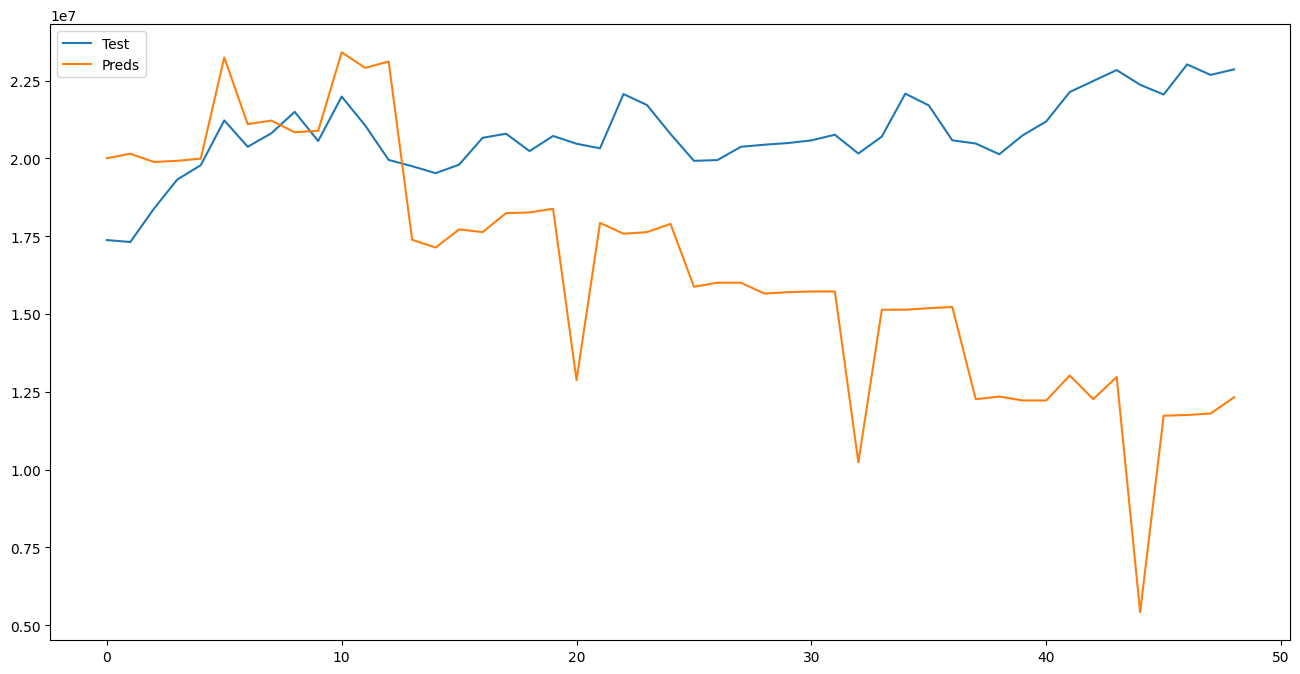

In [219]:
# plot train test and preds
plt.figure(figsize=(16, 8))
plt.plot(y_test_sudeste_np, label='Test')
plt.plot(preds_sudeste_np, label='Preds')
plt.legend()
